In [3]:
from pathlib import Path
import importlib

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt

from dask.distributed import Client
import dask.array
from dask.dataframe.utils import make_meta

from hats import read_hats
from hats.inspection import plot_pixels
from hats_import.catalog.file_readers import CsvReader
from hats_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hats_import.pipeline import ImportArguments, pipeline_with_client

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM
import hpms_pipeline as hpms

print("Imported libraries.")

Imported libraries.


In [4]:
# Change to the directories where the data will be stored
CATALOG_DIR = Path("../../../../catalogs")
MARGIN_CACHE_DIR = CATALOG_DIR / 'margin_caches'

GAIA_NAME = "gaia_dr3_pm_greater_100"
GAIA_DIR = CATALOG_DIR / GAIA_NAME

DES_NAME = "des_light"
DES_DIR = CATALOG_DIR / DES_NAME 

DES_X_GAIA_NAME = "des_dr2_x_gaia_dr3"
DES_X_GAIA_DIR = CATALOG_DIR / DES_X_GAIA_NAME
DES_MARGIN_CACHE_NAME = "des_margin_cache_18_arcsec"
DES_MARGIN_CACHE_DIR = MARGIN_CACHE_DIR / DES_MARGIN_CACHE_NAME

print("Defined directories.")

Defined directories.


In [31]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
check_invalid_mags = True
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,invalidMags=check_invalid_mags)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
k = 2
collinear_error_cutoff = 20
pm_speed_min = 2000 #units are milliseconds per year
pm_speed_max = 10**5
cone_search_rad = 50
max_neighbor_dist = 18
milliarc_degree_conversion = 1/(1000*3600)
print("Defined local vars.")

Defined local vars.


In [6]:
des_catalog = lsdb.read_hats(DES_DIR)
gaia_catalog = lsdb.read_hats(GAIA_DIR)
xmatch_catalog = lsdb.read_hats(DES_X_GAIA_DIR, columns='all')
print("Defined catalogs.")

Defined catalogs.


In [7]:
%%time
pm_filter_xmatch = xmatch_catalog.query(f'{pm_speed_max**2} >(pmra_gaia**2 + pmdec_gaia**2) > {pm_speed_min**2}')
with Client():
    df = pm_filter_xmatch.compute()

df

2025-06-17 13:32:46,778 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/

CPU times: user 29 s, sys: 744 ms, total: 29.7 s
Wall time: 1min 7s


,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,RA_des,DEC_des,COADD_OBJECT_ID_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,source_id_gaia,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153482605725265461,0.844888,0.845371,0.844807,0.845333,0.844827,3,3,3,3,3,1.386363,-37.369781,1043295027,-0.015229,0.040008,0.037639,0.034238,0.050002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2306965202564744064,1.383284,-37.367744,5633.438088,-2334.721273,11.461677
1153482609302817738,0.84542,0.845421,0.845413,0.845344,0.035287,19,19,19,19,19,1.382708,-37.367553,1043296795,0.025377,0.024557,0.017375,0.016744,0.025608,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2306965202564744064,1.383284,-37.367744,5633.438088,-2334.721273,1.786142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206298013938319236,0.001864,0.861837,0.986711,0.059186,0.994785,2,2,2,2,2,331.071881,-56.792344,949223282,-0.017833,0.00133,0.002163,0.036238,0.008708,23.579453,21.088121,17.886377,-99.0,13.975197,0.115939,0.012154,0.001204,-99.0,0.000657,6412596012146801152,331.076453,-56.793812,3981.976663,-2466.831815,10.448522
3206298016903817602,0.768001,0.13328,0.076799,0.102573,0.260082,1,1,1,1,1,331.073253,-56.790655,949223665,0.010093,0.018254,0.007055,-0.004826,-0.005615,-99.0,23.490891,23.837128,-99.0,-99.0,-99.0,0.13595,0.236819,-99.0,-99.0,6412596012146801152,331.076453,-56.793812,3981.976663,-2466.831815,12.998833


In [8]:
df_no_dupes = df[~df['source_id_gaia'].duplicated(keep='first')]

gaia_ids = df['source_id_gaia']

#dropping because otherwise produces error when performing .apply below
df_no_dupes = df_no_dupes.drop('source_id_gaia', axis=1)

df_no_dupes

,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,RA_des,DEC_des,COADD_OBJECT_ID_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153482605725265461,0.844888,0.845371,0.844807,0.845333,0.844827,3,3,3,3,3,1.386363,-37.369781,1043295027,-0.015229,0.040008,0.037639,0.034238,0.050002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.383284,-37.367744,5633.438088,-2334.721273,11.461677
1257518643390044839,0.844564,0.845075,0.845251,0.843732,0.801461,2,2,2,2,2,33.079341,3.567016,1250008459,0.028251,0.024656,0.022653,0.022333,0.032334,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,33.079599,3.567385,-1762.405718,-1852.8711,1.62095
2368327529620177120,0.3251,0.177878,0.293946,0.140421,0.001102,0,0,0,0,0,53.568008,-49.893871,1398391104,-0.006986,0.000464,0.004162,0.024926,0.02906,24.553566,23.715429,23.094166,22.574404,-99.0,0.236298,0.062562,0.070822,0.11552,-99.0,53.567196,-49.890084,2360.592206,483.127504,13.763072
2390050329526096144,0.125803,0.120065,0.028601,0.028627,0.028627,3,3,3,3,3,62.610625,-53.614224,1464092812,0.010486,0.038736,0.037149,0.040352,0.041889,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,62.611,-53.612997,-825.17937,-2415.577565,4.490123
2405297220004419732,0.194207,0.84529,0.84489,0.845284,0.029913,3,3,3,3,3,77.964238,-45.04643,1540617639,0.008839,0.006246,0.002662,0.001698,0.005954,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,77.959937,-45.043813,6491.223339,-5708.61415,14.437522
2423978658324676571,0.845425,0.845425,0.845406,0.845371,0.84513,22,22,18,18,22,50.000054,-43.066641,1445898840,-0.000132,-0.000009,0.000011,0.000009,0.000002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,50.000344,-43.066553,3035.017316,726.964482,0.825611
2450054482295873745,0.844839,0.845014,0.845117,0.845267,0.844982,2,2,2,2,6,5.037242,-64.869108,1054999950,0.000474,0.000276,-0.000397,0.000404,1.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,5.03561,-64.869617,1706.746855,1164.959443,3.096527
2468500457058623057,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,32.623122,-50.820946,1243465193,0.00557,0.00185,0.001703,0.001036,0.004741,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.622946,-50.820906,2125.416147,637.975043,0.425698
2468500457058623057,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,32.623122,-50.820946,1243465193,0.00557,0.00185,0.001703,0.001036,0.004741,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.624069,-50.820823,2168.886011,710.847727,2.199757


In [24]:
def algo_found_pm(row, des_cols, cone_search_rad, query_string, max_neighbor_dist, k, collinear_error_cutoff):    
    # Filter DES around PM of interest:
    filtered_catalog = (
        lsdb.read_hats(DES_DIR, columns=des_cols, margin_cache=DES_MARGIN_CACHE_DIR)
        .cone_search(ra=row['ra_gaia'], dec=row['dec_gaia'], radius_arcsec=cone_search_rad)
        .query(query_string)
    )
    
    xmatch = filtered_catalog.crossmatch(filtered_catalog,
                n_neighbors=100, 
                radius_arcsec=max_neighbor_dist, 
                suffixes=['_1', '_2'])
    xmatch_ddf = xmatch._ddf

    neighbors = xmatch_ddf.groupby('_healpix_29')['_dist_arcsec'].count()
    neighbors -= 1 #Double counting adjustment
    neighbors.name = 'neighbors'
    xmatch_ddf = xmatch_ddf.join(neighbors, on='_healpix_29')
    xmatch_large_groups = xmatch_ddf.query('neighbors >= 3')
    columns_to_keep = (
        [col for col in xmatch_large_groups.columns if col.endswith('_2')]
    )


    meta = make_meta(xmatch_large_groups[columns_to_keep])
    meta['kth_min_proj_error'] = 0.0
    meta['max_obj_distance'] = 0.0
    star_groups = xmatch_large_groups.groupby('_healpix_29').apply(hpms.kth_star_min_distance, meta=meta, k=k-1, cols_to_keep = columns_to_keep, mag_cols=['WAVG_MAG_PSF_I'], max_obj_deviation=collinear_error_cutoff) 
    df = star_groups.compute().reset_index(drop=True, level = 0)
    #To display print statements, include this kwarg in .compute(): scheduler='single-threaded'
    
    if not df.query(f'kth_min_proj_error < {collinear_error_cutoff}').empty:
        min_proj_error = df['kth_min_proj_error'].min()
        min_max_obj_distance = df['max_obj_distance'].min()
        return pd.Series({
            'min_kth_min_proj_error': min_proj_error,
            'min_max_obj_distance': min_max_obj_distance
        })
    else:
        return pd.Series({
            'min_kth_min_proj_error': np.nan,
            'min_max_obj_distance': np.nan
        })
    

In [45]:
importlib.reload(hpms)
print("Done")

Done


In [46]:
res = df_no_dupes.apply(func=algo_found_pm, axis=1, des_cols=des_cols, cone_search_rad=cone_search_rad, query_string=query_string, max_neighbor_dist=max_neighbor_dist, k=k, collinear_error_cutoff=collinear_error_cutoff)
# df_no_dupes['source_id_gaia'] = gaia_ids
print('done')

done


In [47]:
display(res)

,min_kth_min_proj_error,min_max_obj_distance
_healpix_29,,
1153482605725265461,NaN,NaN
1257518643390044839,NaN,NaN
2368327529620177120,1.385788,15.517045
2390050329526096144,NaN,NaN
2405297220004419732,NaN,NaN
2423978658324676571,NaN,NaN
2450054482295873745,NaN,NaN
2468500457058623057,NaN,NaN
2468500457058623057,NaN,NaN


In [48]:
df_combined = df_no_dupes.join(res)
df_combined

,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,RA_des,DEC_des,COADD_OBJECT_ID_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,_dist_arcsec,min_kth_min_proj_error,min_max_obj_distance
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153482605725265461,0.844888,0.845371,0.844807,0.845333,0.844827,3,3,3,3,3,1.386363,-37.369781,1043295027,-0.015229,0.040008,0.037639,0.034238,0.050002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.383284,-37.367744,5633.438088,-2334.721273,11.461677,NaN,NaN
1257518643390044839,0.844564,0.845075,0.845251,0.843732,0.801461,2,2,2,2,2,33.079341,3.567016,1250008459,0.028251,0.024656,0.022653,0.022333,0.032334,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,33.079599,3.567385,-1762.405718,-1852.8711,1.62095,NaN,NaN
2368327529620177120,0.3251,0.177878,0.293946,0.140421,0.001102,0,0,0,0,0,53.568008,-49.893871,1398391104,-0.006986,0.000464,0.004162,0.024926,0.02906,24.553566,23.715429,23.094166,22.574404,-99.0,0.236298,0.062562,0.070822,0.11552,-99.0,53.567196,-49.890084,2360.592206,483.127504,13.763072,1.385788,15.517045
2390050329526096144,0.125803,0.120065,0.028601,0.028627,0.028627,3,3,3,3,3,62.610625,-53.614224,1464092812,0.010486,0.038736,0.037149,0.040352,0.041889,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,62.611,-53.612997,-825.17937,-2415.577565,4.490123,NaN,NaN
2405297220004419732,0.194207,0.84529,0.84489,0.845284,0.029913,3,3,3,3,3,77.964238,-45.04643,1540617639,0.008839,0.006246,0.002662,0.001698,0.005954,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,77.959937,-45.043813,6491.223339,-5708.61415,14.437522,NaN,NaN
2423978658324676571,0.845425,0.845425,0.845406,0.845371,0.84513,22,22,18,18,22,50.000054,-43.066641,1445898840,-0.000132,-0.000009,0.000011,0.000009,0.000002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,50.000344,-43.066553,3035.017316,726.964482,0.825611,NaN,NaN
2450054482295873745,0.844839,0.845014,0.845117,0.845267,0.844982,2,2,2,2,6,5.037242,-64.869108,1054999950,0.000474,0.000276,-0.000397,0.000404,1.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,5.03561,-64.869617,1706.746855,1164.959443,3.096527,NaN,NaN
2468500457058623057,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,32.623122,-50.820946,1243465193,0.00557,0.00185,0.001703,0.001036,0.004741,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.622946,-50.820906,2125.416147,637.975043,0.425698,NaN,NaN
2468500457058623057,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,32.623122,-50.820946,1243465193,0.00557,0.00185,0.001703,0.001036,0.004741,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.622946,-50.820906,2125.416147,637.975043,0.425698,NaN,NaN


In [49]:
def plot_pms_helper(df, check_column, cone_search_rad, title_prefix):
    df_loop = df[~np.isnan(df[check_column])]
    # Get the number of rows that meet the condition
    rows_count = df_loop.shape[0]
    
    # Create subplots
    fig, axs = plt.subplots(rows_count, 1, figsize=(6, rows_count * 4))
    
    # If there is only one subplot, axs is not an array, so we handle it separately
    if rows_count == 1:
        axs = [axs]

    plot_index = 0
    for index, row in df_loop.iterrows():
        filtered_catalog = (
            lsdb.read_hats(DES_DIR, columns=['RA','DEC'])
            .cone_search(ra=row['ra_gaia'], dec=row['dec_gaia'], radius_arcsec=cone_search_rad)
        )
        df_catalog = filtered_catalog.compute()
        RA, DEC = df_catalog[["RA", "DEC"]].to_numpy().T
        
        origin = row['ra_gaia'], row['dec_gaia']

        #multiplied by 3 to show how far the star would travel in 3 years (max time star could move given the time domains of DES and gaia)
        #do not multiply by 3 to have true PM vectors
        vx = (row['pmra_gaia'] / np.cos(np.radians(row['dec_gaia']))) * milliarc_degree_conversion * 3
        vy = row['pmdec_gaia'] * milliarc_degree_conversion * 3
        
        norm = np.sqrt(vx**2 + vy**2)
        
        if norm != 0:
            unit_vector = np.array((vx / norm, vy / norm))
        else:
            unit_vector = np.array((np.nan, np.nan))  # or (0, 0) depending on your use case

        vector = (vx, vy)

        max_dist_vector = unit_vector * row['min_max_obj_distance'] / 3600
        #small displacement to not overlap pm vector
        max_dist_origin = (origin[0], origin[1] - 0.001)


        axs[plot_index].scatter(RA, DEC)
        axs[plot_index].quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='red')
        axs[plot_index].quiver(*max_dist_origin, *max_dist_vector, angles='xy', scale_units='xy', scale=1, color='green')
        axs[plot_index].set_xlabel('RA (Degrees)')
        axs[plot_index].set_ylabel('DEC (Degrees)')
        axs[plot_index].set_title(f'{title_prefix} Stars Near Gaia PMS {index}')
        axs[plot_index].invert_xaxis()

        height = width = (cone_search_rad * 0.5)/3600
        axs[plot_index].set_xlim(row['ra_gaia'] - width, row['ra_gaia'] + width)
        axs[plot_index].set_ylim(row['dec_gaia'] - height, row['dec_gaia'] + height)
        plot_index += 1
    
    plt.tight_layout()
    plt.show()

def plot_found_pms(df, check_column, cone_search_rad):
    plot_pms_helper(df, check_column, cone_search_rad, "Found")

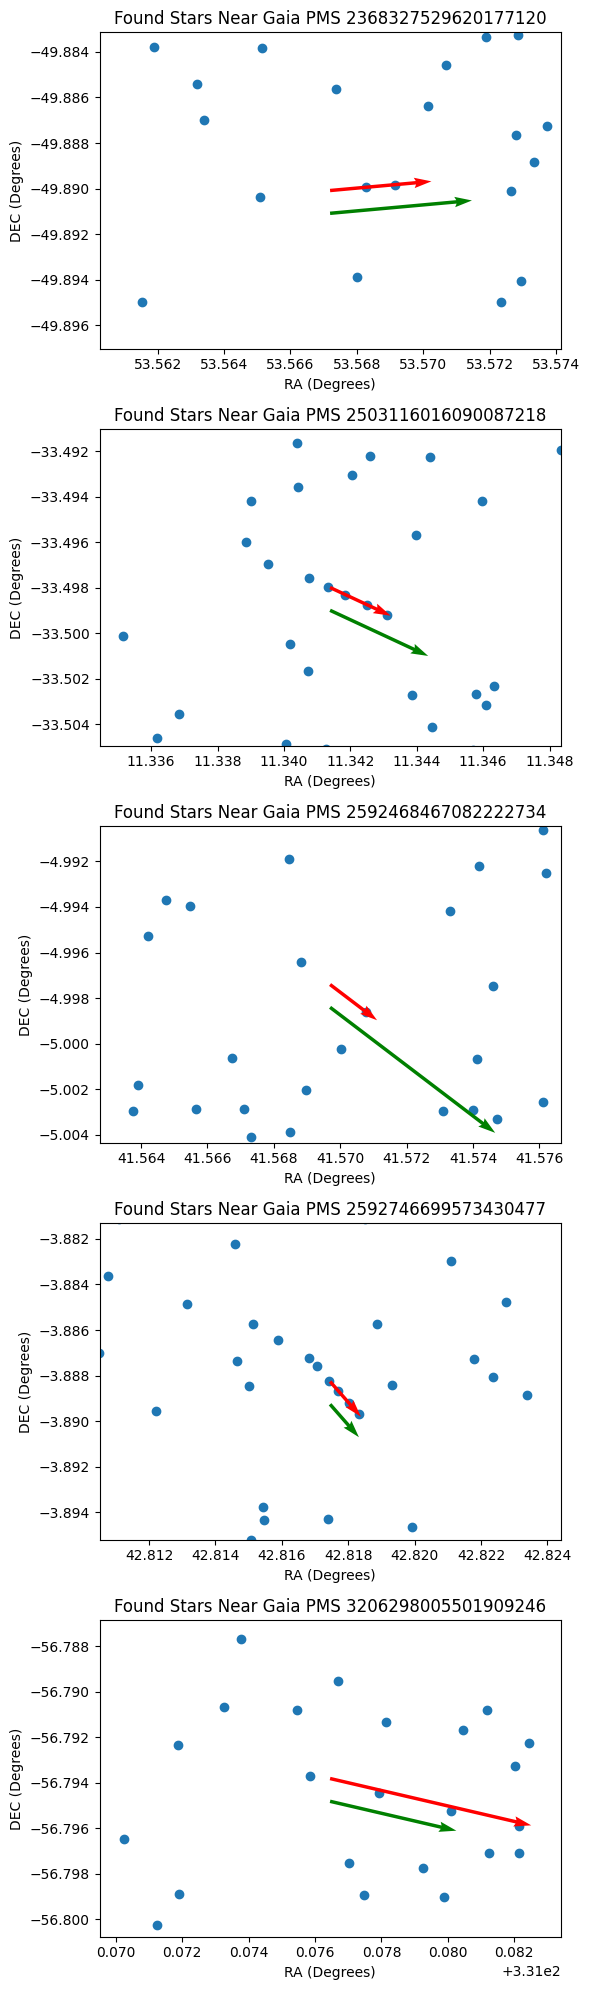

In [50]:
plot_found_pms(df=df_combined, check_column='min_kth_min_proj_error', cone_search_rad=cone_search_rad)